# LD7 - Reverb


In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.linalg import circulant

from IPython.display import Audio
import soundfile as sf

from IPython.core.display import HTML

HTML(
    r"""
<style>
    .jp-MarkdownCell .jp-RenderedHTMLCommon {
        font-family: "Times New Roman", Times, serif;
        font-size: 20px
    }
</style>
"""
)

In [80]:
data, fs = sf.read("balloon-pop.wav")
x = data[:, 0]  # stereo to mono
x = np.concatenate((x, np.zeros(5 * fs)))
t = np.linspace(0, len(x) / fs, len(x))
Audio(data=x, rate=fs)

# Schroeder’s Reverb


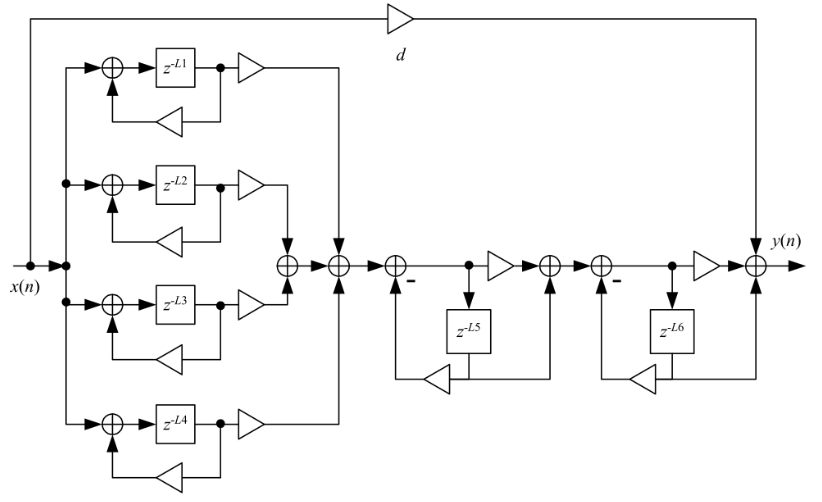


4 comb filter parallel
2 all pass filter cascade


In [82]:
# comb filter
# y[n] = x[n] + g * y[n-k]
def comb(input, delay, gain):
    output = np.zeros(len(input))

    for n in range(len(input)):
        if n >= delay:
            output[n] = input[n] + gain * output[n - delay]
        else:
            output[n] = input[n]
    return output

In [83]:
combSig = comb(x, 5, 0.5)

In [84]:
Audio(data=combSig, rate=fs)

In [85]:
combSig4 = (
    comb(x / 4, 4799, 0.742)
    + comb(x / 4, 4999, 0.733)
    + comb(x / 4, 5399, 0.715)
    + comb(x / 4, 5801, 0.697)
)

In [86]:
Audio(data=combSig4, rate=fs)

In [87]:
# all pass filter
# y[n] = -g * x[n] + x[n-k] + g*y[n-k]
def allPassFilter(input, gain, delay):
    output = np.zeros(len(input))

    for n in range(len(input)):
        if n >= delay:
            output[n] = -gain * input[n] + input[n - delay] + gain * output[n - delay]
        else:
            output[n] = input[n]
    return output

In [88]:
y = 0.6 * x + 0.4 * allPassFilter(allPassFilter(combSig4, 0.7, 1051), 0.7, 337)

In [89]:
Audio(data=y, rate=fs)

# Moorer Reverb


In [99]:
delays_r = [2205, 2469, 2690, 2998, 3175, 3439]
g_list = [0.41, 0.43, 0.45, 0.47, 0.48, 0.50]

In [100]:
combOut = np.zeros_like(x)
for i in range(6):
    combOut = combOut + comb(x, delays_r[i], g_list[i])

In [101]:
Audio(data=combOut, rate=fs)

In [102]:
y = 0.6 * x + 0.4 * allPassFilter(combOut, 0.7, 286)

In [103]:
Audio(data=y, rate=fs)

# Feedback Delay Network

- feedback comb filter
- allpass filter
- low-order damping filter


In [105]:
def damping_filter_coeffs(delays, t_60, alpha):
    
    g = np.zeros(len(delays))
    p = np.zeros(len(delays))
    for i in range(len(delays)):
        g[i] = 10 ** ((-3 * delays[i] * (1 / 44100)) / t_60)
        p[i] = np.log(10) / 4 * (1 - (1 / (alpha**2))) * np.log10(g[i])
    print(g)
    print(p)
    return p, g


def delay(input_signal, delay, gain=1):
    output_signal = np.concatenate((np.zeros(delay), input_signal))[: input_signal.size]
    output_signal = output_signal * gain
    return output_signal


def damping_filter(input_signal, p, g):
    B = np.array([g * (1 - p)])
    A = np.array([1, -p])
    output_signal = np.zeros(input_signal.shape)
    output_signal = signal.lfilter(B, A, input_signal)
    return output_signal


def tonal_correction_filter(input_signal, alpha):
    beta = (1 - alpha) / (1 + alpha)
    E_nomin = np.array([1, -beta])
    E_denomin = np.array([1 - beta])
    output_signal = np.zeros(input_signal.shape)
    output_signal = signal.lfilter(E_nomin, E_denomin, input_signal)
    return output_signal

In [108]:
delay_lens = np.array([601, 1399, 1747, 2269, 2707, 3089, 3323, 3571, 3911, 4127, 4639, 4999])
num_delay_lines = delay_lens.shape[0]
b = 1
c = 1
gain_b = np.full((num_delay_lines, 1), b)
gain_c = np.full((num_delay_lines, 2), c)
gain_c[1::2, 0] *= -1
gain_c[2::4, 1] *= -1
gain_c[3::4, 1] *= -1
init_delay = 0
gain_dry = 1
gain_wet = 1
output_gain = 0.15
alpha = 0.4
t_60 = 1.5
p_coeffs, g_coeffs = damping_filter_coeffs(delay_lens, t_60, alpha)
fm_gain = 1

permutation_matrix = circulant(np.concatenate((np.array([0,1]), np.zeros(len(delay_lens)-2))))
N = permutation_matrix.shape[0]
u_vector = np.ones((N,1))
feedback_matrix = fm_gain * (permutation_matrix - np.matmul((2/N) * u_vector, u_vector.transpose()))


[0.93916903 0.86407868 0.83324166 0.78903725 0.75376082 0.72428468
 0.70680083 0.68873141 0.6647072  0.64988194 0.61604794 0.59331863]
[0.08237224 0.19174503 0.23944144 0.31098605 0.37101773 0.42337413
 0.45544585 0.48943639 0.53603633 0.56564099 0.63581501 0.68515612]


In [124]:
# sample_in = 'balloon-pop.wav'
# frame_rate = 44100.0

# wav_file = wave.open(sample_in, 'r')
# num_samples_sample = wav_file.getnframes()
# num_channels_sample = wav_file.getnchannels()
# sample = wav_file.readframes(num_samples_sample)
# total_samples_sample = num_samples_sample * num_channels_sample
# wav_file.close()
    
# sample = struct.unpack('{n}h'.format(n = total_samples_sample), sample)
# sample = np.array([sample[0::2], sample[1::2]], dtype = np.float64)
# sample[0] /= np.max(np.abs(sample[0]), axis = 0)
# sample[1] /= np.max(np.abs(sample[1]), axis = 0)
    
data, fs = sf.read("balloon-pop.wav")
x = data[:, 0]  # stereo to mono
x = np.concatenate((x, np.zeros(3 * fs)))
#t = np.linspace(0, len(x) / fs, len(x))

sample = np.array([x, x])
output_to_correct = np.zeros((sample.shape))
output_wet = np.zeros((sample.shape))

In [127]:
for channel in range(2):
        
    print(np.shape(sample[channel].reshape(1,sample.shape[1])))

    sample_mx = np.tile(sample[channel,:], (num_delay_lines,1))
    sample_mx_out = np.zeros((sample_mx.shape))
    feedback_out_A = np.empty([num_delay_lines, sample_mx.shape[1]])
    feedback_out = np.zeros((feedback_out_A.shape))
    feedback_out_A = np.matmul(gain_b, sample[channel].reshape(1,sample.shape[1]))
        
    cnt = 0
    
    while True:
        for i in range(sample_mx.shape[0]):
            feedback_out_B = delay(feedback_out_A[i] + feedback_out[i], delay_lens[i])
            feedback_out_C = damping_filter(feedback_out_B, p_coeffs[i], g_coeffs[i]) 
            sample_mx_out[i] = feedback_out_C
                
        if np.array_equal(np.matmul(feedback_matrix, sample_mx_out), feedback_out):
            break
        cnt = cnt + 1
        feedback_out = np.matmul(feedback_matrix, sample_mx_out)

    print(cnt)
        
    output_to_correct[channel] = np.sum(sample_mx_out * gain_c[:, channel].reshape(gain_b.shape), axis = 0)
    output_wet[channel] = tonal_correction_filter(output_to_correct[channel], alpha)
    output_wet[channel] = delay(output_wet[channel], int(round(44.1 * init_delay)))

output = output_gain * (output_wet * gain_wet + (sample * gain_dry)).reshape(sample.shape)
        

(1, 84672)
83
(1, 84672)
83


In [126]:
Audio(data=output, rate=fs)

# References


- https://github.com/radoslawregula/reverb-algorithms/tree/master
